In [230]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy


In [231]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [232]:
q_lower = np.linspace(0, y_train.mean(), 5)
q_upper = np.linspace(y_train.mean(), 1, 5)

In [233]:
quantiles = np.concatenate((q_lower, q_upper))

In [234]:
quantiles = np.insert(quantiles, 3, 0.5)

In [235]:
# quantiles = [y_train.mean() - .05, y_train.mean(), y_train.mean() + 0.05]

In [236]:
quantiles = np.linspace(0, 1, 11)

In [237]:
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [238]:
def get_weight_tensor_from_class_weights(y, class_weights: list):
    weights = torch.empty_like(y).float()
    
    for i, weight in enumerate(class_weights):
        weights[y == i] = weight.item()
    
    return weights
        

In [239]:
class Canonical(nn.Module):
    def __init__(self):
        super(Canonical, self).__init__()
        self.z = nn.Linear(44, 64)
        self.bn = nn.BatchNorm1d(64)
        self.quantile_preds = nn.ModuleList([nn.Linear(64, 1) for _ in range(1)])
        
    def forward(self, x):
        z = self.bn(self.z(x))
        
        return [self.quantile_preds[i](z) for i in range(len(self.quantile_preds))]

In [240]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.z = nn.Linear(44, 64)
        self.bn = nn.BatchNorm1d(64)
        self.quantile_preds = nn.ModuleList([nn.Linear(64, 1) for _ in range(len(quantiles))])
        
    def forward(self, x):
        z = self.bn(self.z(x))
        
        return [self.quantile_preds[i](z) for i in range(len(self.quantile_preds))]

In [241]:
canonical = Canonical()

In [242]:
optimizer = SGD(canonical.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)

In [243]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    outputs = canonical(data)
    losses = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs[i], 
        target, 
        weight=get_weight_tensor_from_class_weights(target, np.array([0.5, 0.5]))
    ) for i in range(len(outputs))]
    
    loss = sum(losses)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        outputs_val = canonical(data_val)
        losses_val = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs_val[i], 
        target_val, 
        weight=get_weight_tensor_from_class_weights(target_val, np.array([0.5, 0.5]))
        ) for i in range(len(outputs))]
    
        loss_val = sum(losses_val) 
        
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

0.30709177255630493
0.17015808820724487
0.09221139550209045
0.09034936130046844
0.09021566063165665
0.08739610761404037
0.08621843159198761
0.08606377243995667
0.08593201637268066
0.08595214784145355
0.0860113650560379
0.08600518107414246
0.08599139004945755
0.08598771691322327
0.08599290996789932
0.08599577099084854
0.08599328994750977


In [244]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [245]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [246]:
model = NN()

In [247]:
model.z = canonical.z

In [248]:
model.z.weight.requires_grad = False
model.z.bias.requires_grad = False

In [249]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [250]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    outputs = model(data)
    losses = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs[i], 
        target, 
        weight=get_weight_tensor_from_class_weights(target, [quantiles[i], 1 - quantiles[i]])
    ) for i in range(len(outputs))]
    
    loss = sum(losses)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        outputs_val = model(data_val)
        losses_val = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs_val[i], 
        target_val, 
        weight=get_weight_tensor_from_class_weights(target_val, [quantiles[i], 1 - quantiles[i]])
        ) for i in range(len(outputs))]
    
        loss_val = sum(losses_val) 
        
        print(loss_val.item())
                    
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

3.780406951904297
2.3394455909729004
0.9494673013687134
0.7427178025245667
0.688396692276001
0.6695437431335449
0.6583784222602844
0.6515651345252991
0.6496391892433167
0.6487367749214172
0.6473656892776489
0.6464085578918457
0.6457938551902771
0.6453506946563721
0.644997775554657
0.6446378231048584
0.6443440318107605
0.6440882682800293
0.6438761353492737
0.6436855792999268
0.6435173153877258
0.6433658003807068
0.6432316899299622
0.6431119441986084
0.6430047154426575
0.64290851354599
0.6428223252296448
0.6427448391914368
0.6426751017570496
0.6426125764846802
0.6425563097000122
0.6425058245658875
0.6424606442451477
0.6424199938774109
0.642383873462677
0.6423514485359192
0.6423225402832031
0.6422968506813049
0.6422739624977112
0.6422537565231323
0.6422358751296997
0.6422199606895447
0.6422061324119568
0.6421938538551331
0.6421831250190735
0.642173707485199
0.6421655416488647
0.6421584486961365
0.6421521902084351
0.6421469449996948
0.6421424150466919
0.6421383619308472
0.6421350836753845


0.641549289226532
0.6415489912033081
0.6415486335754395
0.6415483355522156
0.6415480971336365
0.6415477991104126
0.641547441482544
0.6415470838546753
0.641546905040741
0.6415465474128723
0.641546368598938
0.6415460705757141
0.6415457725524902
0.6415455341339111
0.6415452361106873
0.6415449380874634
0.6415446996688843
0.6415444612503052
0.6415442228317261
0.641543984413147
0.6415437459945679
0.641543447971344
0.6415432691574097
0.6415429711341858
0.6415428519248962
0.6415426135063171
0.641542375087738
0.6415421962738037
0.6415418982505798
0.6415416598320007
0.6415414810180664
0.6415412425994873
0.641541063785553
0.6415408253669739
0.6415407061576843
0.6415404081344604
0.6415402293205261
0.641539990901947
0.6415397524833679
0.6415396332740784
0.6415393948554993
0.6415392756462097
0.6415390372276306
0.6415389180183411
0.641538679599762
0.6415385603904724
0.6415383815765381
0.6415382027626038
0.6415380239486694
0.6415377855300903
0.6415376663208008
0.641537606716156
0.6415374279022217
0.64

In [251]:

from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

from pacmagic.general_utils.constants import *
from pacmagic.modeling.survival_models.kaplan_meier import get_and_fit_kaplan_meier
from pacmagic.visualizing.visualization_settings import *
from pacmagic.visualizing.visualization_utils import set_default_style

# Calibration curve
COLOR_TRAIN_ROC = 'b'
STD_AUC_FIELD = 'std_auc'
MEAN_FPR_FIELD = 'mean_fpr'
MEAN_TPR_FIELD = 'mean_tpr'
COLOR_TEST_ROC = 'orange'
LINE_WIDTH = 2
COLOR_PREDICTIONS = 'green'
PREDICTED_DIST_BINS = 40

LABEL_PERFECTLY_CALIBRATED = 'Perfectly calibrated'
LABEL_PREDICTIONS = 'Predictions'
LABEL_CI = 'Confidence Interval'

Y_PROB_COL = 'y_prob'
Y_TRUE_COL = 'y_true'
Y_CI_UPPER_COL = 'y_ci_upper'
Y_CI_LOWER_COL = 'y_ci_lower'
GROUP_COL = 'group'

set_default_style()

LEGEND_LOCATION_BEST = 'best'
HAZARD_PLOT_X_LABEL = 'time $t$'
HAZARD_PLOT_Y_LABEL = 'Est. probability of survival at t'
STEP_PLACEMENT = 'post'

ACTUAL_END_SCATTER_SIZE = 80
ORDER_IN_FRONT = 1

MARKER_CENSORING = 'o'
MARKER_EVENT = 'D'
SURVIVAL_MARKERSIZE = 10
SURVIVAL_MARKERFACECOLOR = 'grey'
SURVIVAL_LEGEND_COLOR = 'w'

def plot_calibration_curve(y_true, y_prob,
                           y_min: float = 0,
                           y_max: float = 1,
                           n_bins: int = 5,
                           n_std: int = 4,
                           y_std=None,
                           n: int = None,
                           z: float = 1.645,
                           ) -> Figure:
    """Plot the calibration curve. This curve shows if predicted probabilities and observed
    frequencies are inline. For example, if well calibrated 100 observations with y_pred = 0.1
    should contain 10 observation with y_true = 1

    Parameters
    ----------
    y_true : array-like
        Target value of y.
    y_prob : array-like
        Predicted probability values of y.
    y_min : float, optional
        Minimum value of the value axis.
    y_max : float, optional
        Maximum value of the value axis, y_pred > y_max will be maximized to y_max.
    n_bins : int, optional
        Number of bins of the histograms.
    n_std : int, optional
        Number of standard deviations to include.
    y_std: array-like, optional
        If you have a Bayesian standard deviation around your predictions
    n: int, optional
        Number of samples taken (in Bayesian Case)
    z: float, optional
        Z value for confidence interval.

    Returns
    -------
    type: matplotlib.figure.Figure
        A plot

    """

    # Make dataframe with y_true and y_pred
    df_plot = pd.DataFrame(y_prob)
    df_plot.columns = [Y_PROB_COL]
    df_plot[Y_TRUE_COL] = y_true
    if y_std is not None:
        df_plot[Y_CI_UPPER_COL] = y_prob + z * (y_std / n ** 0.5)
        df_plot[Y_CI_LOWER_COL] = y_prob - z * (y_std / n ** 0.5)

    # Initialize plot
#     # Make histogram of predicted probabilities
#     x = df_plot[Y_PROB_COL].values
#     x = np.maximum(np.minimum(x, y_max), y_min)
#     ax1.hist(x, bins=n_bins, color=SKYBLUE_COLOR)

    # Overlay the calibration curve
    mean = df_plot[Y_PROB_COL].mean()
    std = df_plot[Y_PROB_COL].std()

    # Make bins for the calibration
    df_plot[GROUP_COL] = df_plot[Y_PROB_COL].apply(lambda a: np.round((a - mean) / std))
    df_plot[GROUP_COL] = np.minimum(np.maximum(df_plot[GROUP_COL], -n_std), n_std)
    df_plot[GROUP_COL] = df_plot[GROUP_COL].apply(lambda a: mean + std * a)
    df_plot[GROUP_COL] = np.maximum(np.minimum(df_plot[GROUP_COL], y_max), y_min)

    
    df_agg = df_plot.groupby(GROUP_COL)[Y_TRUE_COL, Y_PROB_COL].mean().reset_index()

    y_u = None
    y_l = None

    x = df_agg[Y_PROB_COL]
    y = df_agg[Y_TRUE_COL]

    # Plot the calibration curve
    return x, y
#     plt.plot(x, x, DOT_LINE_STYLE, color=COLOR_NEUTRAL, label=LABEL_PERFECTLY_CALIBRATED)
    
    return fig


In [252]:
outputs = [torch.sigmoid(output) for output in outputs]

In [253]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_train, output.detach().numpy()))

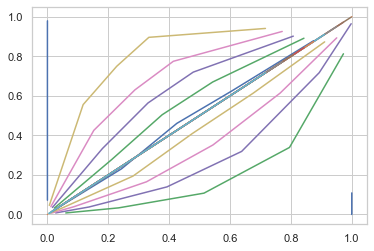

In [254]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [255]:
from pacmagic.visualizing.model_plots import plot_calibration_curve

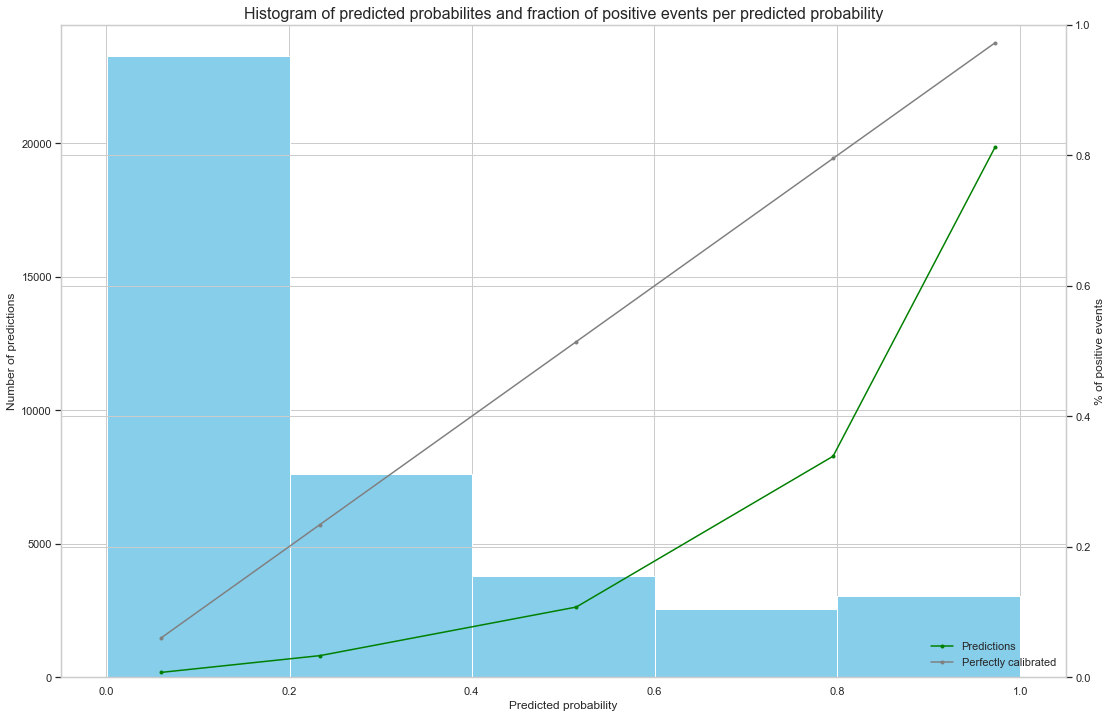

In [256]:
plot_calibration_curve(y_train, outputs[1].detach().numpy())

In [257]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [258]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 5], 100 * (1-y_train.values.mean()))
cutoff

0.27900001406669617

In [259]:
preds = (outputs_val > cutoff)

In [260]:
(preds == np.repeat(y_test.values, 11, axis=1)).mean(axis=0)

array([0.087782  , 0.74000447, 0.85459013, 0.90373018, 0.92204601,
       0.93343757, 0.93902167, 0.94237212, 0.93969176, 0.93343757,
       0.912218  ])

In [261]:
preds_50 = preds[:, 5]

In [262]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.9334375698012062

In [263]:
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [264]:
(preds == np.repeat(y_test.values, 11, axis=1)).any(axis=1).mean()

1.0

In [265]:
(preds[:, 1: 10] == np.repeat(y_test.values, 9, axis=1)).any(axis=1).mean()

0.9890551708733527

In [266]:
preds[:, 1].mean(), preds[:, 9].mean()

(0.3285682376591467, 0.02389993299084208)

In [267]:
(preds[:, 2 : 9] == np.repeat(y_test.values, 7, axis=1)).any(axis=1).mean()

0.9778869778869779

In [268]:
preds[:, 2].mean(), preds[:, 8].mean()

(0.19968729059638152, 0.03819522001340183)

In [269]:
(preds[:, 3:  8] == np.repeat(y_test.values, 5, axis=1)).any(axis=1).mean()

0.9656019656019657

In [270]:
preds[:, 3].mean(), preds[:, 7].mean()

(0.1380388653115926, 0.052937234755416576)

In [271]:
(preds[:, 4 : 7] == np.repeat(y_test.values, 3, axis=1)).any(axis=1).mean()

0.9510833147196783

In [272]:
preds[:, 4].mean(), preds[:, 6].mean()

(0.10587446951083315, 0.06477551932097386)

In [273]:
(preds[:, 5:6] == np.repeat(y_test.values, 2, axis=1)).any(axis=1).mean()

0.9334375698012062

In [274]:
preds[:, 5].mean(), preds[:, 5].mean()

(0.08376144739781104, 0.08376144739781104)

In [275]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.9334375698012062

In [276]:
uncertainties = []

In [277]:
uncertainties = outputs_val[:, 4] - outputs_val[:, 6]

In [278]:
preds_50 == y_test.values

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [279]:
outputs_val[:, 5][preds_50 == y_test.squeeze().values]

array([0.006, 0.016, 0.095, ..., 0.018, 0.047, 0.045], dtype=float32)

(0.12457718, 0.031504426)

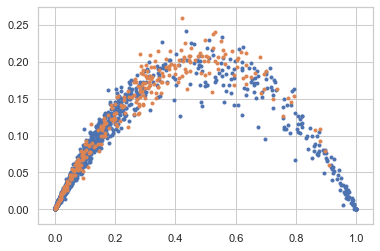

In [280]:
plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')


plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')


uncertainties[preds_50 != y_test.squeeze().values].mean(), uncertainties[preds_50 == y_test.squeeze().values].mean()


In [281]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 5]
y_unc = uncertainties

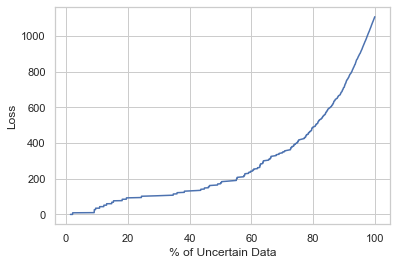

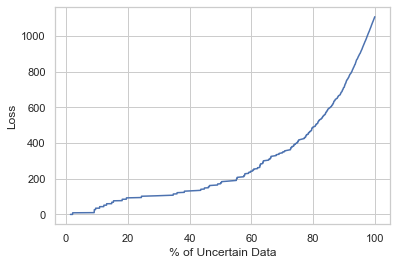

In [282]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

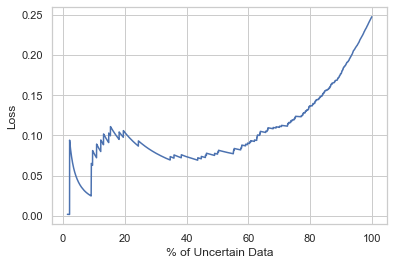

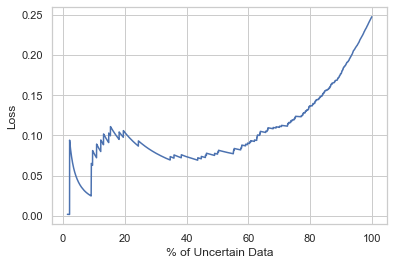

In [283]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

In [284]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [285]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [286]:
uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())

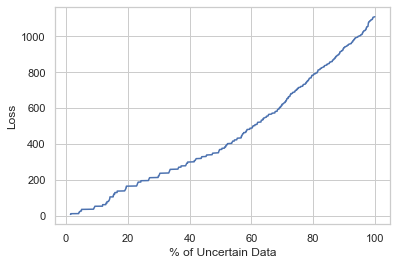

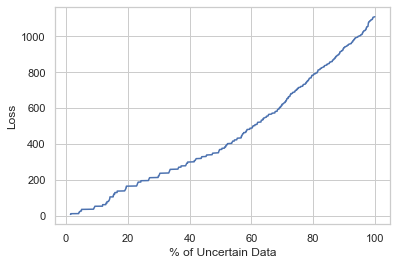

In [287]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

In [288]:
cross_entropy(y_true, y_prob, reduction='sum')

1109.6616156327073

In [289]:
# loss at 50%
y_50 = y_true[y_unc.argsort()[:int(0.5 * len(y_unc))]]
y_prob_50 = y_prob[y_unc.argsort()[:int(0.5 * len(y_unc))]]

In [290]:
cross_entropy(y_50, y_prob_50, reduction='sum')

172.057600148255